In [1]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from collections import Counter

transactions = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
sample_submission = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
# /kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv
# /kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv
# /kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv
# /kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv

plt.rcParams["figure.figsize"] = (15,5)

In [2]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [3]:
sample_submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


# Data analysis

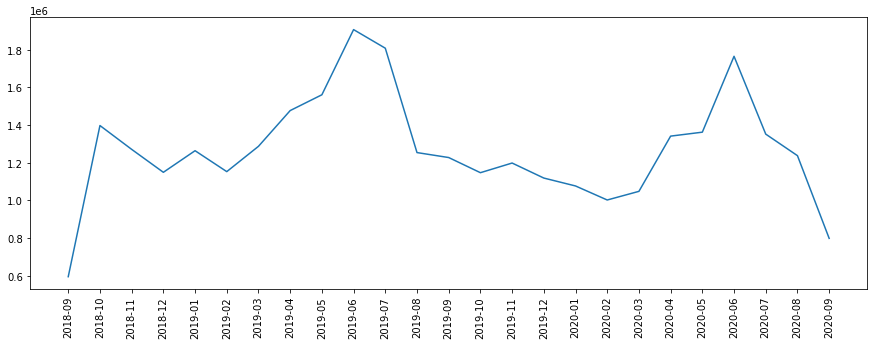

In [4]:
# Sold products over the years
df = transactions
df['year_month'] = df['t_dat'].apply(lambda x : x.split('-')[0]+'-'+x.split('-')[1])
df = df.groupby(['year_month']).count().reset_index()
_ = plt.plot(df['year_month'], df['t_dat'])
_ = plt.xticks(rotation=90)

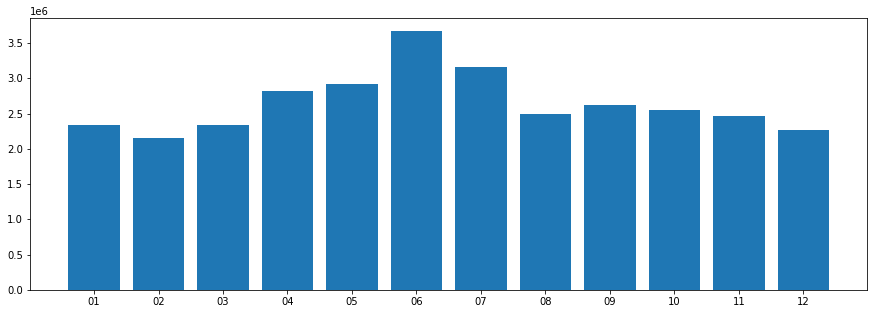

In [5]:
# Sold product each month
df = transactions
df['month'] = df['t_dat'].apply(lambda x : x.split('-')[1])
df = df.groupby(['month']).count().reset_index()
_ = plt.bar(df['month'], df['t_dat'], align='center')

       article_id  customer_id
53832   706016001        50287
53833   706016002        35043
1711    372860001        31718
24808   610776002        30199
70124   759871002        26329
...           ...          ...
8205    521266001            1
36666   651538001            1
8211    521302001            1
36710   651645003            1
13340   557727001            1

[104547 rows x 2 columns]


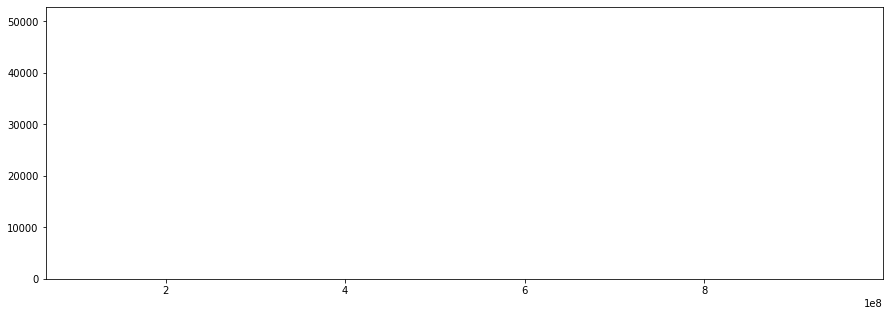

In [6]:
# Top products
df = transactions.groupby(['article_id']).count().reset_index()[["article_id", "customer_id"]].sort_values(["customer_id"], ascending=False)
print(df)
_ = plt.bar(df['article_id'], df['customer_id'], align='center')

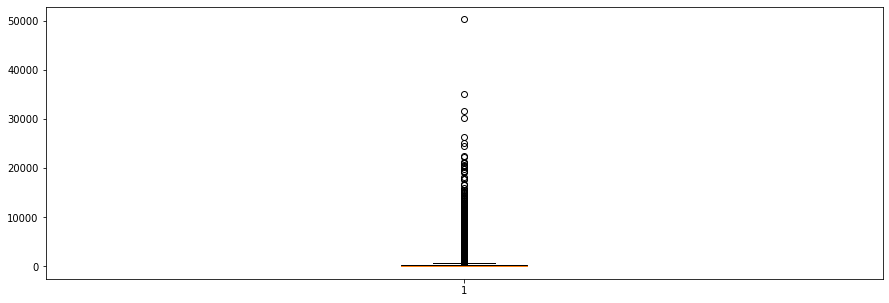

In [7]:
_ = plt.boxplot(df['customer_id'])

In [8]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,year_month,month
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,2018-09,09
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,2018-09,09
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2018-09,09
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,2018-09,09
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,2018-09,09
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2,2020-09,09
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2,2020-09,09
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1,2020-09,09
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1,2020-09,09


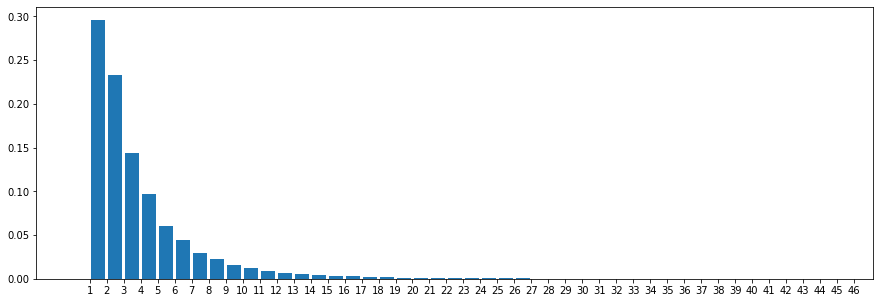

In [9]:
# Number of products by basket (considering one day = one basket as we do not have order_id)
transactions_gb = transactions.groupby(['t_dat', 'customer_id'])['article_id'].apply(list).reset_index()  
transactions_gb["len_basket"] = transactions_gb["article_id"].apply(lambda x: len(x))
transactions_gb = transactions_gb.sort_values(["len_basket"])

# Taking off outliers
transactions_gb_t = transactions_gb[:len(transactions_gb['len_basket'])-2000]

# Plot
_ = plt.hist(transactions_gb_t['len_basket'], density=True, bins=range(max(list(set(transactions_gb_t['len_basket'])))), rwidth=0.8)
_ = plt.xticks(list(set(transactions_gb_t['len_basket'])))

# Cleaning + create train and test dataset

In [10]:
# Truncate transactions since the data is too large for Kaggle cluster
transactions = transactions[transactions["t_dat"]>='2020-07-01']

In [11]:
# Considering each article_id as str
transactions['article_id'] = transactions['article_id'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# Splitting train and test as 30%
test_set = 0.3
train_set = (1-test_set)
split = int(transactions.shape[0]*train_set)

transactions_train = transactions.sort_values('t_dat').iloc[:split]
transactions_test = transactions.sort_values('t_dat').iloc[split:]
print("Train set size :", transactions_train.shape[0])
print("Test set size :", transactions_test.shape[0])

Train set size : 2370874
Test set size : 1016089


# Baseline : Best sellers recommender

Our Baseline will be the well known best sellers.

In [13]:
class BestSeller():
    """FIXME"""
    def __init__(self):
        """FIXME"""
        pass
    
    def fit(self, X):
        """FIXME"""
        self.X_occur = Counter(list(X['article_id']))
        self.best_sellers_10 = [article_id for (article_id, occ) in self.X_occur.most_common(10)]
        return self
    
    def predict(self, basket, k=10):
        """FIXME"""
        if k==10:
            return self.best_sellers_10
        else:
            best_sellers = [article_id for (article_id, occ) in self.X_occur.most_common(k)]
            return best_sellers

In [14]:
bs_model = BestSeller()
bs_model.fit(transactions_train)

In [15]:
bs_model.predict([])

['706016001',
 '372860002',
 '610776002',
 '751471001',
 '730683050',
 '760084003',
 '759871002',
 '866383006',
 '464297007',
 '610776001']

# Cosine Similarity

Cosine similarity is a measure of similarity that can be used to get the similarity of two objects. It uses the cosine value between two vectors to compute the similarity of two data points. As the distances between the vectors increases, the similiraty reduces.

In [16]:
from math import sqrt

class CosineSim():
    """FIXME"""
    def __init__(self):
        """FIXME"""
        pass
    
    def _get_l_of_two_from_l(self, l):
        """FIXME"""
        # Dropping duplicates to avoid having more co-occur than occur
        l = list(set(l))
        if len(l)>1:
            l_of_two = []
            for i in range(0,len(l)):
                for j in range(i+1,len(l)):
                    if int(l[i])<int(l[j]):
                        l_of_two.append(f"{l[i]}|{l[j]}")
                    else:
                        l_of_two.append(f"{l[j]}|{l[i]}")
            return l_of_two
        return None
    
    def _get_frequency(self, article_id, counter_occur_article_id):
        """FIXME"""
        return counter_occur_article_id[article_id]
    
    def _get_co_occ_frequency(self, article_id_a, article_id_b, counter_co_occ_article_id):
        """FIXME"""
        if int(article_id_a) < int(article_id_b):
            str_co_occ = article_id_a + '|' + article_id_b
        else:
            str_co_occ = article_id_b + '|' + article_id_a
        return counter_co_occ_article_id[str_co_occ]
    
    def _get_cosine_sim(self, freq_a, freq_b, co_occ_freq):
        """FIXME"""
        return (co_occ_freq/sqrt(freq_a*freq_b))
        
    def fit(self, X, top_n=200, threshold=0.005):
        """FIXME"""        
        # Keeping only top N articles
        start_time = time.time()
        counter_article_id = Counter(X['article_id'])
        list_top_n = sorted(counter_article_id, key=counter_article_id.get, reverse=True)[:top_n]
        X = X[X['article_id'].isin(list_top_n)]
        print("--- %s seconds ---" % (time.time() - start_time))
        
        # Getting baskets
        start_time = time.time()
        X_grouped = X.groupby(['t_dat', 'customer_id'])['article_id'].apply(list).reset_index()
        print("--- %s seconds ---" % (time.time() - start_time))
        
        # Getting frequencies of article_ids
        start_time = time.time()
        l_baskets_len2 = list(X_grouped[X_grouped['article_id'].map(len) >1]['article_id'])
        l_baskets_len2_flat_list = [x for xs in l_baskets_len2 for x in xs]
        counter_occur_article_id = Counter(l_baskets_len2_flat_list)
        print("--- %s seconds ---" % (time.time() - start_time))

        # Getting co-occur frequencies of article_ids
        start_time = time.time()
        l_co_occur_article_id = []
        for basket in l_baskets_len2:
            l_of_two = self._get_l_of_two_from_l(basket)
            if l_of_two:
                l_co_occur_article_id += l_of_two

        counter_co_occ_article_id = Counter(l_co_occur_article_id)
        print("--- %s seconds ---" % (time.time() - start_time))
        
        # Creating pandas dataframe
        start_time = time.time()
        l_article_id_a = [i.split('|', 1)[0] for i in l_co_occur_article_id]
        l_article_id_b = [i.split('|', 1)[1] for i in l_co_occur_article_id]
        df_cosine = pd.DataFrame()
        df_cosine['article_id_a'] = l_article_id_a
        df_cosine['article_id_b'] = l_article_id_b
        print("--- %s seconds ---" % (time.time() - start_time))
        
        start_time = time.time()
        df_cosine['freq_a'] = df_cosine['article_id_a'].apply(lambda x : self._get_frequency(x, counter_occur_article_id))
        print("--- %s seconds ---" % (time.time() - start_time))
        
        start_time = time.time()
        df_cosine['freq_b'] = df_cosine['article_id_b'].apply(lambda x : self._get_frequency(x, counter_occur_article_id))
        print("--- %s seconds ---" % (time.time() - start_time))
        
        start_time = time.time()
        df_cosine['co_occ_freq'] = df_cosine.apply(lambda x: self._get_co_occ_frequency(x.article_id_a, x.article_id_b, counter_co_occ_article_id), axis=1)
        print("--- %s seconds ---" % (time.time() - start_time))
        
        start_time = time.time()
        df_cosine['cosine_sim'] = df_cosine.apply(lambda x: self._get_cosine_sim(x.freq_a, x.freq_b, x.co_occ_freq), axis=1)
        print("--- %s seconds ---" % (time.time() - start_time))
        
        df_cosine = df_cosine.sort_values('cosine_sim', ascending=False)
        
        # Filtering with threshold
        self.df_cosine = df_cosine[df_cosine["cosine_sim"]>threshold]

        return self
    
    def predict(self, basket, k=10, strat='mean'):
        """FIXME"""
        df = self.df_cosine[(self.df_cosine['article_id_a'].isin(basket)) & (~self.df_cosine['article_id_b'].isin(basket))]
        
        if strat=='mean':
            result = list(df[['article_id_b', 'cosine_sim']].groupby(['article_id_b']).mean().reset_index()['article_id_b'])[:k]
        elif strat=='max':
            result = list(df[['article_id_b', 'cosine_sim']].groupby(['article_id_b']).max().reset_index()['article_id_b'])[:k]
        else:
            result = []
        return result

In [17]:
# FIXME : Optimize for loops, taking ages to run
cs_model = CosineSim().fit(transactions_train, top_n=500)

--- 1.353865623474121 seconds ---
--- 6.303035020828247 seconds ---
--- 0.2114112377166748 seconds ---
--- 0.48657703399658203 seconds ---
--- 0.19665002822875977 seconds ---
--- 0.15726828575134277 seconds ---
--- 0.15502619743347168 seconds ---
--- 6.334677457809448 seconds ---
--- 7.953211307525635 seconds ---


In [18]:
cs_model.predict(['610776001'])

['610776002',
 '610776068',
 '610776071',
 '610776072',
 '610776074',
 '610776083',
 '624486001',
 '624486064',
 '673396002',
 '678942001']

# ALS

In [19]:
!pip install pyspark > /dev/null

In [20]:
import pyspark

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession

In [21]:
conf = SparkConf().set("spark.ui.port", "4050") \
                  .set('spark.executor.memory', '9G') \
                  .set('spark.driver.memory', '7G') \
                  .set('spark.sql.autoBroadcastJoinThreshold', '-1')

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/30 22:29:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [22]:
# from pyspark.ml.recommendation import ALS, ALSModel

In [23]:
# Mapping on whole dataset
customer_map = transactions[["customer_id"]].drop_duplicates().reset_index(drop=True)
customer_map["USER"] = customer_map.index

item_map = transactions[["article_id"]].drop_duplicates().reset_index(drop=True)
item_map["ITEM"] = item_map.index

customer_map_dict = dict(zip(customer_map['USER'].values, customer_map['customer_id'].values))
item_map_dict = dict(zip(item_map['ITEM'].values, item_map['article_id'].values))


In [24]:
transactions_train_als = (
        transactions_train
        .merge(customer_map, on="customer_id", how="inner")
        .merge(item_map, on="article_id", how="inner")
    )

In [25]:
transactions_train_als.head()

,t_dat,customer_id,article_id,price,sales_channel_id,year_month,month,USER,ITEM
0,2020-07-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,0.013542,2,2020-07,07,0,0
1,2020-07-01,a6b01c312b405648213358b2dabd281da24a41d614e1a6...,825577003,0.013542,2,2020-07,07,10926,0
2,2020-07-01,ad46e9981871bf1b30179b591f9e4c12905667f2b7b19b...,825577003,0.013542,2,2020-07,07,11300,0
3,2020-07-01,bce7727c6492066c74f9aa9fc7780ec83ae685da29e53c...,825577003,0.013542,2,2020-07,07,12342,0
4,2020-07-01,88ee51fed6c213029fbd2255a8ab5b5671194e3ef7c64b...,825577003,0.013542,2,2020-07,07,8975,0


In [26]:
df_ratings = transactions_train_als.head(1000).groupby(['USER', 'ITEM']).count().reset_index()[["USER", "ITEM", "price"]]
df_ratings.columns = ['USER', 'ITEM', 'RATING']

In [27]:
df_ratings

,USER,ITEM,RATING
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,2
4,0,4,1
...,...,...,...
886,382409,4,1
887,383643,10,1
888,385210,7,1
889,385559,1,1


In [28]:
df_ratings_ps = spark.createDataFrame(df_ratings) 
print(df_ratings_ps.printSchema())
print(df_ratings_ps.show())

root
 |-- USER: long (nullable = true)
 |-- ITEM: long (nullable = true)
 |-- RATING: long (nullable = true)

None


+----+-----+------+
|USER| ITEM|RATING|
+----+-----+------+
|   0|    0|     1|
|   0|    1|     1|
|   0|    2|     1|
|   0|    3|     2|
|   0|    4|     1|
|   0|    5|     1|
|   0|    6|     1|
|   0|    7|     1|
|   0|    8|     1|
|   0|    9|     1|
|   0|   10|     1|
|   0| 4654|     1|
|   0| 8016|     2|
|   0|11924|     1|
|   0|13862|     1|
|   0|19446|     1|
|  10|    9|     1|
| 167|13862|     1|
| 262|    1|     1|
| 321|    0|     1|
+----+-----+------+
only showing top 20 rows

None


In [29]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select("RATING").count()

    # Count the number of distinct userIds and distinct articleIds
    total_elements = ratings.select("USER").distinct().count() * ratings.select("ITEM").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")
    
get_mat_sparsity(df_ratings_ps)

The ratings dataframe is  93.57% sparse.


In [30]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ALS model
als = ALS(
         userCol="USER", 
         itemCol="ITEM",
         ratingCol="RATING", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [31]:
# Import the requisite packages
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [32]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

In [33]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="RATING", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


In [34]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [35]:
# Fit cross validator to the 'train' dataset
model = cv.fit(df_ratings_ps)

# Extract best model from the cv model above
best_model = model.bestModel

In [36]:
print("Best Model")
print("Rank:", best_model._java_obj.parent().getRank())
print("MaxIter:", best_model._java_obj.parent().getMaxIter())
print("RegParam:", best_model._java_obj.parent().getRegParam())

Best Model
Rank: 10
MaxIter: 10
RegParam: 0.1


In [37]:
recommendations = best_model.recommendForAllUsers(5)

In [38]:
recommendations.show(10, False)

+----+------------------------------------------------------------------------------------------+
|USER|recommendations                                                                           |
+----+------------------------------------------------------------------------------------------+
|262 |[{1, 0.9135527}, {3, 0.77192265}, {0, 0.702261}, {8, 0.7012728}, {13862, 0.664732}]       |
|321 |[{0, 0.91106945}, {3, 0.7471995}, {1, 0.7224341}, {8, 0.60241127}, {8016, 0.5999031}]     |
|1136|[{9, 0.9168418}, {4, 0.8134418}, {8016, 0.7581417}, {7, 0.7286532}, {3, 0.6768819}]       |
|1166|[{0, 0.91106945}, {3, 0.7471995}, {1, 0.7224341}, {8, 0.60241127}, {8016, 0.5999031}]     |
|1167|[{0, 1.8221389}, {3, 1.494399}, {1, 1.4448682}, {8, 1.2048225}, {8016, 1.1998062}]        |
|1644|[{0, 0.91106945}, {3, 0.7471995}, {1, 0.7224341}, {8, 0.60241127}, {8016, 0.5999031}]     |
|1997|[{0, 1.8221389}, {3, 1.494399}, {1, 1.4448682}, {8, 1.2048225}, {8016, 1.1998062}]        |
|2142|[{4, 0.9172826

In [39]:
# def history_basket_als(X_test, als):
#     """FIXME"""
#     recommendations = als.recommendForAllUsers(5)

In [40]:
# transactions_test_als = (
#         transactions_test
#         .merge(customer_map, on="customer_id", how="inner")
#         .merge(item_map, on="article_id", how="inner")
#     )

In [41]:
# transactions_test_als

In [42]:
# transactions_test_als.head(1000).groupby(['t_dat','customer_id', 'USER']).ITEM.apply(list).reset_index().head(1000)

In [43]:
# # View the predictions
# test_predictions = best_model.transform(test)
# RMSE = evaluator.evaluate(test_predictions)
# print(RMSE)

In [44]:
## OLD WORK
# customer_map = transactions[["customer_id"]].drop_duplicates().reset_index(drop=True)
# customer_map["USER"] = customer_map.index

# item_map = df[["article_id"]].drop_duplicates().reset_index(drop=True)
# item_map["ITEM"] = item_map.index

# customer_map_dict = dict(zip(customer_map['USER'].values, customer_map['customer_id'].values))
# item_map_dict = dict(zip(item_map['ITEM'].values, item_map['article_id'].values))

In [45]:
# transactions_train['article_id'] = transactions_train['article_id'].astype(str)
# transactions_train.info()

In [46]:
# transactions_train_als = (
#         transactions_train
#         .merge(customer_map, on="customer_id", how="inner")
#         .merge(item_map, on="article_id", how="inner")
#     )
# transactions_train_als["rating"] = 1

In [47]:
# transactions_train_als.head()

In [48]:
# mod = 10000000
# transactions_train_als = transactions_train[["customer_id", "article_id"]].head(1000)
# transactions_train_als["rating"] = 1
# transactions_train_als['customer_id_hash'] = transactions_train_als['customer_id'].apply(lambda x : hash(x) % mod)
# transactions_train_als['article_id_hash'] = transactions_train_als['article_id'].apply(lambda x : hash(x) % mod)

In [49]:
# transactions_train_als_spark = spark.createDataFrame(transactions_train_als) 

In [50]:
# transactions_train_als_spark.show()

In [51]:
# als = ALS(userCol="customer_id_hash", itemCol="article_id_hash", ratingCol="rating", coldStartStrategy="drop")

# # param_grid = ParamGridBuilder().addGrid(als.rank, [25]) \
# #                                .addGrid(als.regParam, [0.1, 0.15]) \
# #                                .addGrid(als.maxIter, [10]) \
# #                                .build()

In [52]:
# model = als.fit(transactions_train_als_spark)

In [53]:
# transactions_test_als = transactions_test[["customer_id", "article_id"]].head(1000)
# #transactions_test_als["rating"] = 1
# transactions_test_als['customer_id_hash'] = transactions_test_als['customer_id'].apply(lambda x : hash(x) % mod)
# transactions_test_als['article_id_hash'] = transactions_test_als['article_id'].apply(lambda x : hash(x) % mod)
# transactions_test_als_spark = spark.createDataFrame(transactions_test_als) 

In [54]:
# predictions = model.transform(transactions_test_als_spark)

In [55]:
# predictions.show()

In [56]:
# !pip install --upgrade implicit

In [57]:
# import implicit

In [58]:
# model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
# model.fit(coo_train)

In [59]:
# transactions_train.head()

In [60]:
# transactions_train_als = transactions_train[["customer_id", "article_id"]].head(1000)
# transactions_train_als["rating"] = 1

In [61]:
# !pip install pyspark

In [62]:
# import pyspark

# from pyspark.ml.recommendation import ALS

# als = ALS(maxIter=5, regParam=0.01, userCol="customer_id", itemCol="article_id", ratingCol="rating", coldStartStrategy="drop")
# # model = als.fit(transactions_train_als)

In [63]:
# from pyspark.ml.recommendation import ALS

# als = ALS(maxIter=10, regParam=1, userCol="USER", itemCol="ITEM", ratingCol="RATING", coldStartStrategy="drop", implicitPrefs=True, alpha=100, rank=200, seed=1)

# Evaluating recommenders

In [64]:
def is_predicted(customer_id, order, model, k, debug=False):
    """FIXME"""
    if debug:
        print("##")
        print("order:", order)
    order_ = order.copy()
    hidden_article_id = order_.pop(random.randrange(len(order_)))
    visible_order = order_
    
    start_time = time.time()
    predictions = model.predict(visible_order, k)
    if debug:
        print(time.time() - start_time)
    
    if debug:
        print("visible_order:", visible_order)
        print("predictions:", predictions)
        print("hidden_article_id:", hidden_article_id)
    
    if hidden_article_id in predictions:
        if debug:
            print(1)
        return 1
    else:
        if debug:
            print(0)
        return 0

In [65]:
def history_basket_performance(X, model, k=10):
    """FIXME"""
    # Grouping to have orders by day
    X_orders = X.groupby(['t_dat', 'customer_id'])['article_id'].apply(list).reset_index()    
    
    # Keeping only orders where we can hide at least one article and have at least one item in our basket
    X_orders['is_long_enough'] = X_orders['article_id'].apply(lambda x: 1 if(len(x)>1) else 0)
    X_orders = X_orders[X_orders['is_long_enough']==1]
        
    v_is_predicted = np.vectorize(lambda x, y, model, k: is_predicted(x, y, model, k))

    X_orders['predicted'] = v_is_predicted(X_orders.customer_id, X_orders.article_id, model, k)

    is_predicted_count = X_orders[X_orders['predicted']==1].shape[0]
    count = X_orders.shape[0]
    
    return (count, is_predicted_count/count)

In [66]:
history_basket_performance(transactions_test.head(1000), bs_model)

(230, 0.017391304347826087)

In [67]:
history_basket_performance(transactions_test.head(1000), cs_model)

(230, 0.021739130434782608)

In [68]:
# (205, 0.24878048780487805)

# Evaluating top_n in cosine_sim

In [69]:
# [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
l_top_n = [350, 500, 750, 1000, 1250, 1500, 2000]
l_perf = []
for top_n in l_top_n:
    print("##")
    print(top_n)
    cs_model = CosineSim().fit(transactions_train, top_n)
    perf = history_basket_performance(transactions_test.head(3000), cs_model)
    l_perf.append(perf[1])
    print(perf)

##
350
--- 0.8520350456237793 seconds ---
--- 5.242396116256714 seconds ---
--- 0.1661379337310791 seconds ---
--- 0.34273386001586914 seconds ---
--- 0.16624951362609863 seconds ---
--- 0.12357592582702637 seconds ---
--- 0.10404372215270996 seconds ---
--- 4.254295110702515 seconds ---
--- 5.52678918838501 seconds ---
(688, 0.010174418604651164)
##
500
--- 0.7843461036682129 seconds ---
--- 7.9958226680755615 seconds ---
--- 0.2137155532836914 seconds ---
--- 0.4921739101409912 seconds ---
--- 0.2559926509857178 seconds ---
--- 0.18002724647521973 seconds ---
--- 0.1705458164215088 seconds ---
--- 6.269280910491943 seconds ---
--- 8.372557878494263 seconds ---
(688, 0.0188953488372093)
##
750
--- 0.8687756061553955 seconds ---
--- 7.5851686000823975 seconds ---
--- 0.26464319229125977 seconds ---
--- 0.7463462352752686 seconds ---
--- 0.39125752449035645 seconds ---
--- 0.2918221950531006 seconds ---
--- 0.2474498748779297 seconds ---
--- 10.090497016906738 seconds ---
--- 12.7978396

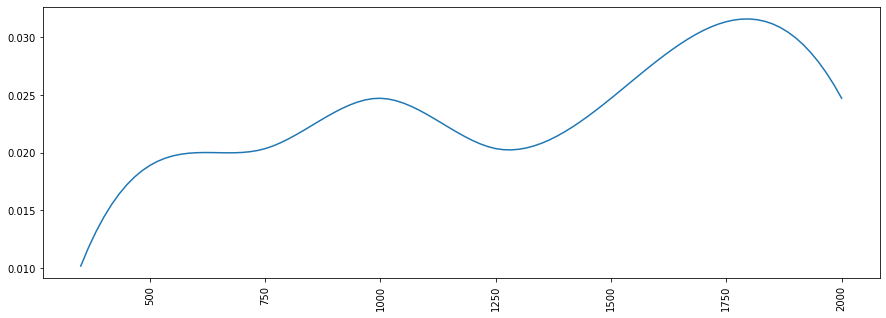

In [70]:
from scipy.interpolate import make_interp_spline

x = np.array(l_top_n)
y = np.array(l_perf)

X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers over a specified interval.
X_ = np.linspace(x.min(), x.max(), 100)
Y_ = X_Y_Spline(X_)

_ = plt.plot(X_, Y_)
_ = plt.xticks(rotation=90)